# Novel measures of the racial wealth gap, and how UBI would help close it

*By Will Fedder and Max Ghenis*

The large racial wealth gap traces its roots to slavery, redlining, and other discriminatory policies, and persists largely due to [racial income gaps](https://www.bloomberg.com/news/articles/2019-03-21/how-income-inequality-feeds-the-racial-wealth-gap).
In honor of Black History month, we explore how closing part of this income gap with a universal basic income would affect the racial wealth gap, using novel measurements that consider how Black and White families differ across the full wealth distribution.
 
The two most common measures of the racial wealth gap simply compare mean and median wealth between White and Black families.[^head]
Based on the 2019 Survey of Consumer Finances[^scf], White families have mean wealth 5.7 times that of Black families, and median wealth 6.4 times that of Black families.

[^head]: White and Black families are families headed by a White and Black person, respectively.

[^scf]: We used the [Policy Simulation Library](http://pslmodels.org)'s [`scf`](https://github.com/PSLmodels/scf) and [`microdf`](https://github.com/PSLmodels/microdf) Python packages for extracting and processing this data in [this script](https://github.com/UBICenter/blog/blob/master/jb/20210228/data/gen_data.py).

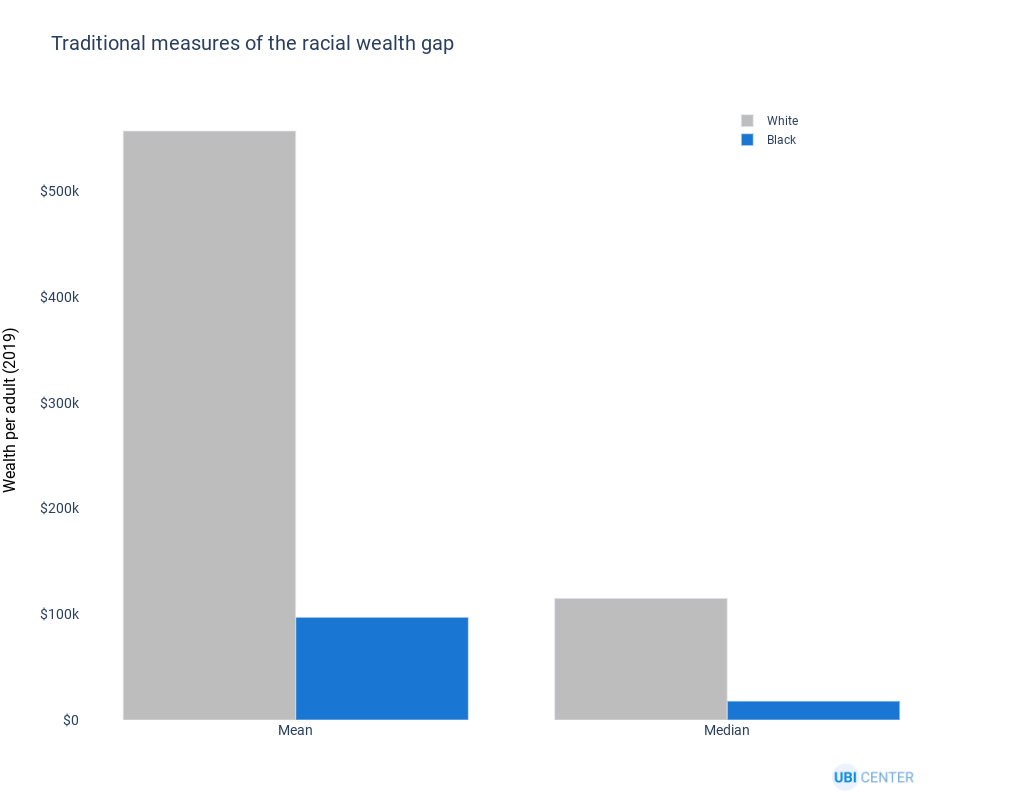

In [1]:
import warnings

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import ubicenter
from plotly.subplots import make_subplots

cdfs = pd.read_csv("data/cdfs.csv")
ubi_summary = pd.read_csv("data/ubi_summary.csv")
nw_quant = pd.read_csv("data/deciles.csv")


# Define UBI Center colors
BLUE = "#1976D2"
DARK_BLUE = "#1565C0"
LIGHT_BLUE = "#90CAF9"
GRAY = "#BDBDBD"
DARK_GRAY = "#616161"
BARELY_BLUE = "#E3F2FD"

colors = [BLUE, DARK_BLUE, LIGHT_BLUE, GRAY, BARELY_BLUE]

bl = ubi_summary.iloc[0].round(-2)
params = pd.DataFrame(
    {
        "Mean": {
            "White": bl.white_mean_networth_pa,
            "Black": bl.black_mean_networth_pa,
        },
        "Median": {
            "White": bl.white_median_networth_pa,
            "Black": bl.black_median_networth_pa,
        },
    }
)

fig = go.Figure(
    data=[
        go.Bar(name="White", x=params.T.index, y=params.T["White"], marker_color=GRAY),
        go.Bar(name="Black", x=params.T.index, y=params.T["Black"], marker_color=BLUE),
    ]
)

fig.update_layout(
    title="Traditional measures of the racial wealth gap",
    hovermode="x",
    xaxis_title="",
    yaxis_title="Wealth per adult (2019)",
    yaxis_tickprefix="$",
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.75),
)

ubicenter.format_fig(fig)

As Matt Bruenig pointed out in his [June 2020 piece](https://www.peoplespolicyproject.org/2020/06/29/the-racial-wealth-gap-is-about-the-upper-classes/), the mean wealth gap is largely shaped by overall wealth inequality, with over 70 percent of both Black and White families' wealth held by the top decile.

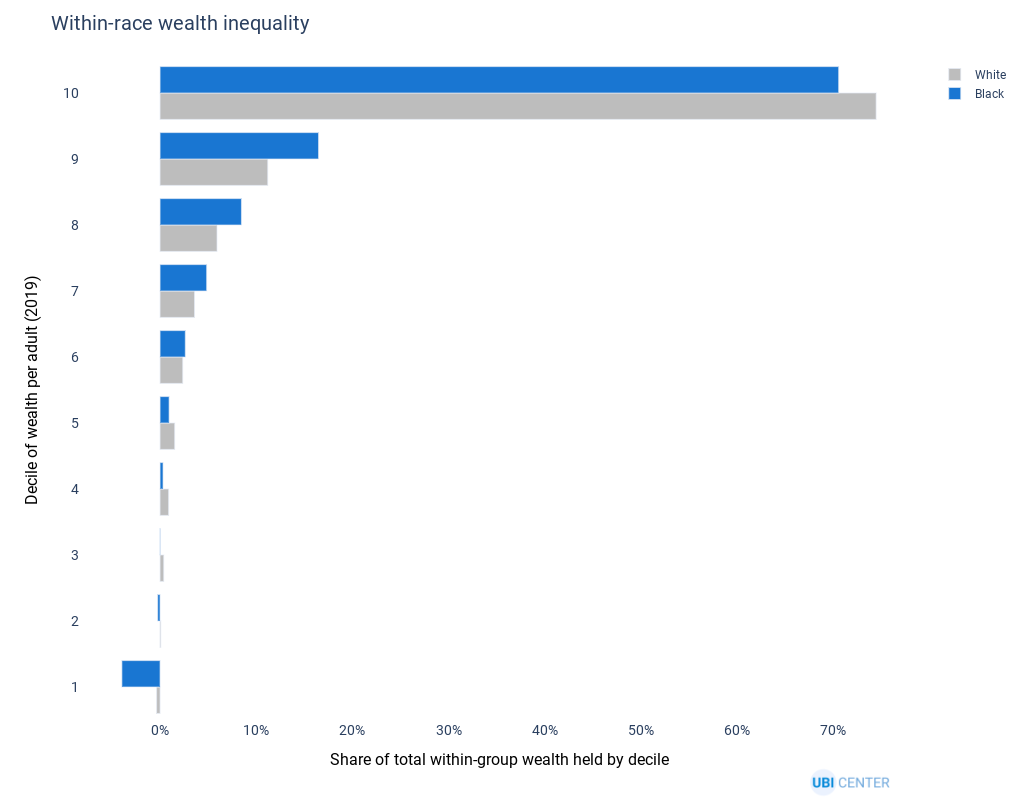

In [2]:
hovertemplate = "%{x:.1f}%"

fig = px.bar(
    nw_quant[nw_quant.variable.isin(["White", "Black"])],
    y="percentile",
    x="value",
    color="variable",
    labels={
        "percentile": "Percent receiving benefit",
        "value": "Share of within-group wealth",
    },
    orientation="h",
    barmode="group",
    color_discrete_map={"White": GRAY, "Black": BLUE},
)

fig.update_traces(hovertemplate="Share of Wealth: " + hovertemplate)

# apply formatting
fig.update_layout(
    title="Within-race wealth inequality",
    hovermode="y",
    xaxis_title="Share of total within-group wealth held by decile",
    yaxis_title="Decile of wealth per adult (2019)",
    xaxis_ticksuffix="%",
    legend_title="",
    yaxis_dtick=1,
)

ubicenter.format_fig(fig)

While the median tells us where the middle of the distributions lay, it can obscure what is going on throughout the rest of the distribution.
To visualize a variable's distribution in full, we can turn to the cumulative distribution function (CDF), which shows the population share with less than a specified value.

The following graph shows how to interpret a CDF graph of of wealth per adult for all families in the U.S. (Note that while we have logarithmically transformed the x-axis, the y-axis remains linear.)

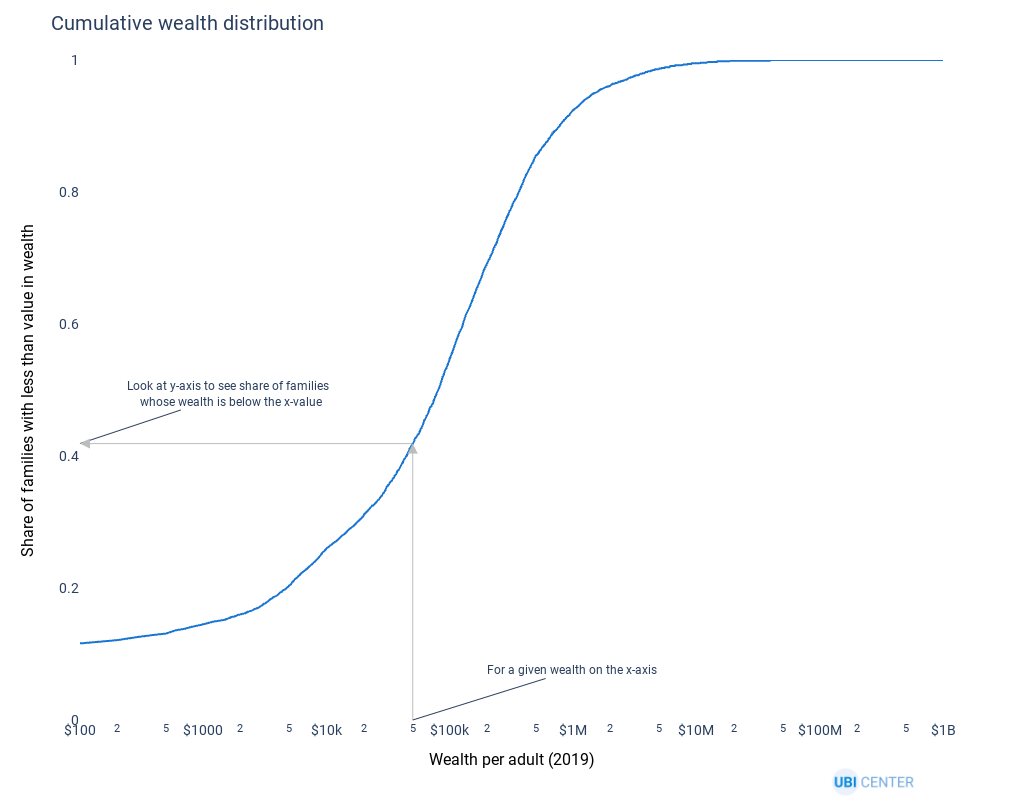

In [3]:
all_hh = cdfs.loc[cdfs.ubi_mo == 0].copy(deep=True)

# select 5000k
med = all_hh.loc[all_hh["networth_pa_new"] == 50000, :].copy(deep=True)
med["x"] = np.log10(med.networth_pa_new)
med["y"] = med.loc[:, "total_share"]

# plot curve
fig = px.line(x=all_hh.networth_pa_new, y=all_hh.total_share.round(3))
# change line coloar
fig["data"][0]["line"]["color"] = BLUE

# add explanation for arrow pointing to y-axis
fig.add_annotation(
    x=2,
    y=med.y.values[0],
    text="Look at y-axis to see share of families <br> whose wealth is below the x-value",
    showarrow=True,
    arrowhead=0,
    ay=-50,
    ax=150,
)

# add dotted line pointing from x-axis to point
fig.add_annotation(
    x=med.x.values[0],
    y=0,
    text="For a given wealth on the x-axis",
    showarrow=True,
    arrowhead=0,
    # yshift=-60,
    # xshift=-130,
    ax=160,
    ay=-50,
)

# add red arrow pointing from x-axis to point
fig.add_annotation(
    x=med.x.values[0],  # arrows' head
    y=med.y.values[0],  # arrows' head
    ax=med.x.values[0],  # arrows' tail
    ay=0,  # arrows' tail
    xref="x",
    yref="y",
    axref="x",
    ayref="y",
    text="",  # if you want only the arrow
    showarrow=True,
    arrowhead=2,
    arrowsize=2,
    arrowwidth=1,
    arrowcolor=GRAY,
)

# add arrow pointing from point to y-axis
fig.add_annotation(
    x=2,  # arrows' head
    y=med.y.values[0],  # arrows' head
    ax=med.x.values[0],  # arrows' tail
    ay=med.y.values[0],  # arrows' tail
    xref="x",
    yref="y",
    axref="x",
    ayref="y",
    text="",  # if you want only the arrow
    showarrow=True,
    arrowhead=2,
    arrowsize=2,
    arrowwidth=1,
    arrowcolor=GRAY,
)

fig.update_layout(
    showlegend=False,
    title="Cumulative wealth distribution",
    xaxis_title="Wealth per adult (2019)",
    yaxis_title="Share of families with less than value in wealth",
    yaxis_ticksuffix="",
    yaxis_tickprefix="",
    xaxis_tickprefix="$",
    hovermode="x",
)

fig.update_xaxes(
    dict(
        range=[2, 9],
        autorange=False,
        showspikes=False,  # Show spike line for x-axis
        # Format spike
        spikethickness=1,
        spikedash="dot",
        spikecolor="grey",
        spikemode="toaxis",
    ),
    type="log",
)
fig.update_yaxes(
    dict(
        range=[0, 1],
        showspikes=True,
        spikethickness=1,
        spikedash="dot",
        spikecolor="grey",
        spikemode="toaxis",
    )
)

ubicenter.format_fig(fig)

Now, how can we compare the distributions of wealth between Black and White families?
The two-sample Kolmogorov-Smirnov (KS) statistical test offers a way to test the difference between two distributions.
The KS statistic, or D-statistic (for "distance"), is the maximum absolute vertical distance between two CDFs.

One advantage to this statistical method is that it is quite simple to explain visually.
The below chart plots the CDF for White and Black families.
The dotted line drawn between the two curves shows where the vertical distance between them is at its greatest.

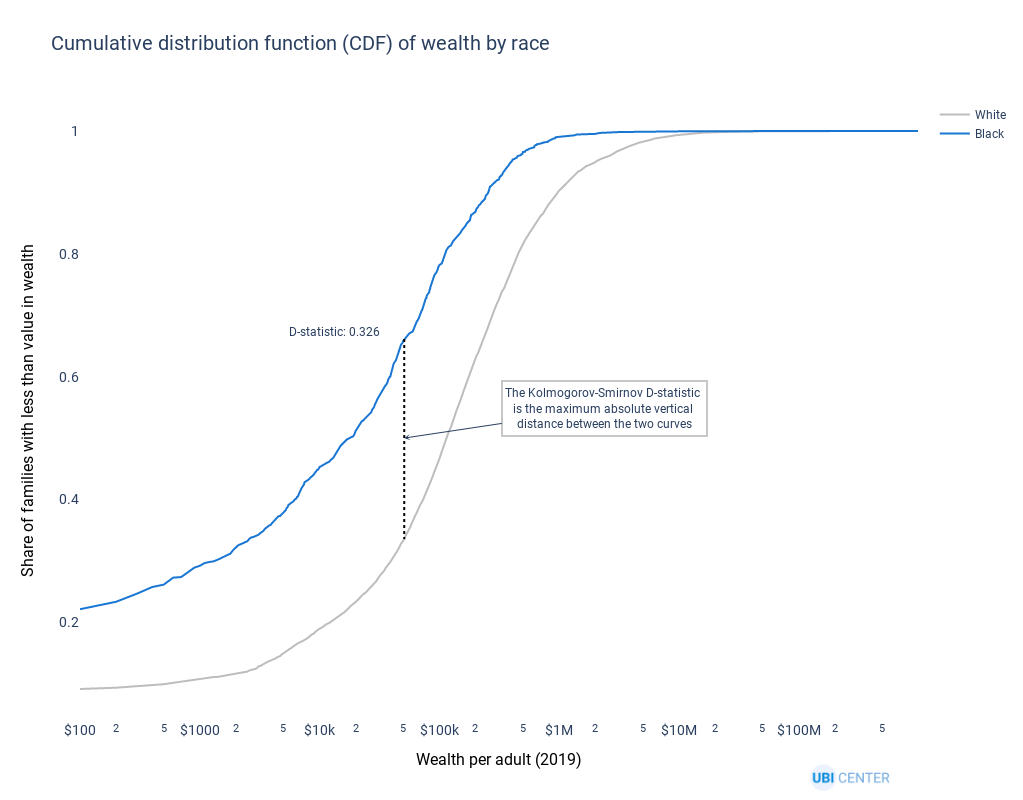

In [4]:
with warnings.catch_warnings():  # ignore "FutureWarning"
    """
    Ignore numpy 'FutureWarning' :
    "Using a non-tuple sequence for multidimensional indexing is deprecated;
    use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be
    interpreted as an array index, `arr[np.array(seq)]`, which will result
    either in an error or a different result."
    """
    warnings.filterwarnings("ignore", category=FutureWarning)

    # Create traces
    fig = go.Figure()

    # create df for baseline
    cdfs_bl = cdfs[cdfs.ubi_mo == 0]
    # plot ECDFs
    fig.add_trace(
        go.Scatter(
            x=cdfs_bl.networth_pa_new,
            y=cdfs_bl.white_share,
            name="White",
            marker_color=GRAY,
        )
    )
    fig.add_trace(
        go.Scatter(
            x=cdfs_bl.networth_pa_new,
            y=cdfs_bl.black_share,
            name="Black",
            marker_color=BLUE,
        )
    )

    # define ks_stat
    ks_stat = ubi_summary.loc[ubi_summary.ubi_mo == 0, "d_stat_cand"].max()

    # find networth where the d-statistic is found
    max_x = ubi_summary.loc[ubi_summary.ubi_mo == 0, "networth_pa_new"].max()

    # find networth where abs distance between ecdfs is is @  max
    y1 = ubi_summary.loc[ubi_summary.ubi_mo == 0, "white_share"].max()
    y0 = ubi_summary.loc[ubi_summary.ubi_mo == 0, "black_share"].max()

    # # add a dashed line showing where max abs distance between ECDFs is

    dash_names = "Max abs. distance between CDFs"
    dash_color = "black"
    fig.add_trace(
        go.Scatter(
            x=[max_x, max_x],
            y=[y0, y1],
            mode="lines+text",
            line={"dash": "dot", "color": dash_color, "width": 2},
            visible=True,
            name=dash_names,
            text=["D-statistic: " + str(round(ks_stat, 3)) + "        ", None],
            textposition="top left",
            showlegend=False,
        )
    )

    fig.add_annotation(
        x=np.log10(max_x),
        y=(y1 + y0) / 2,
        text="The Kolmogorov-Smirnov D-statistic <br>"
        + "is the maximum absolute vertical <br>"
        + "distance between the two curves",
        showarrow=True,
        arrowhead=3,
        yshift=1,
        ax=200,
        bordercolor="#c7c7c7",
        borderwidth=2,
        borderpad=4,
        bgcolor="dark blue",
        opacity=1,
    )

    fig.update_layout(
        title="Cumulative distribution function (CDF) of wealth by race",
        xaxis_title="Wealth per adult (2019)",
        yaxis_title="Share of families with less than value in wealth",
        yaxis_ticksuffix="",
        yaxis_tickprefix="",
        xaxis_tickprefix="$",
    )

    fig.update_xaxes(type="log")
    ubicenter.format_fig(fig)

This shows us that approximately 65.9% of Black families have a wealth of less than \$50,000 per adult, whereas only 33.3% of White families fall below that line.
As we will see, the threshold can be at any point along these curves; the KS statistic is the value measuring the size of the gap where the gap is the largest, at 0.326 (the actual wealth value corresponding to the D-statistic was \$50,888).

In the following model, we simulate how saving a total of one year’s UBI payments could change the racial wealth gap. We apply a flat tax on all income to fund the UBI program, and subtract each family's new tax payment from their wealth. 
 
In the bottom graph, you can see the vertical distance between the two curves at each point along the x-axis from \$0 to \$2,000 per month.

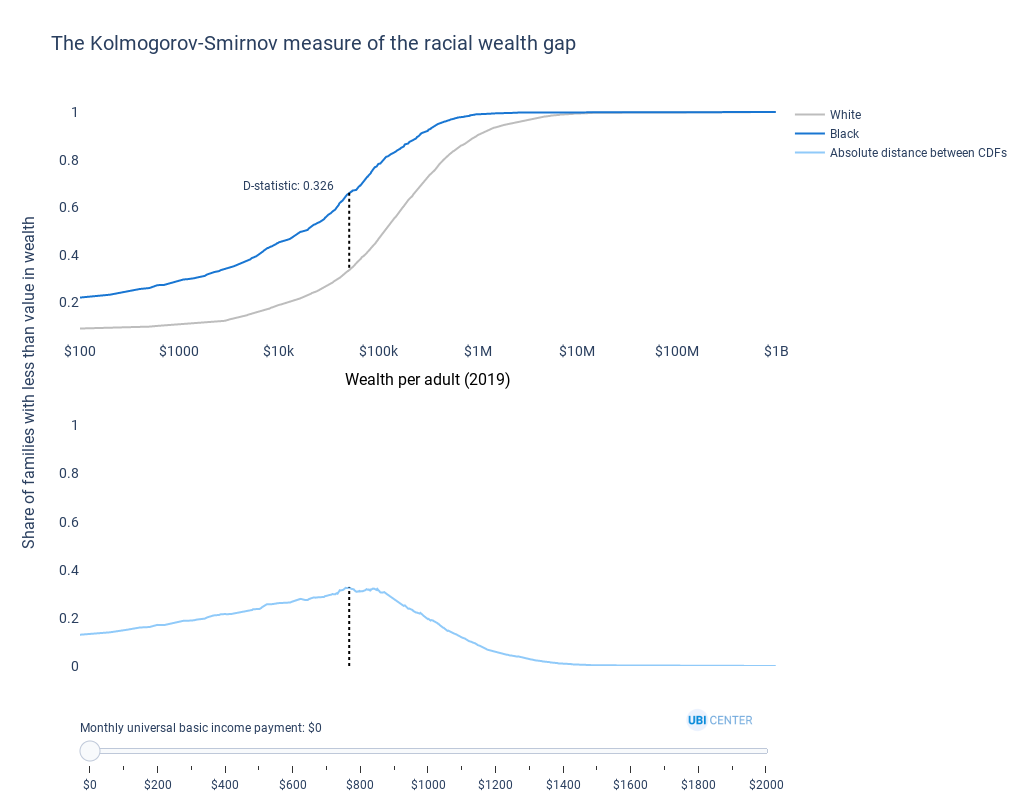

In [5]:
def ecdf_slider(data):
    # Create traces
    fig = go.Figure()

    # create empty list for payment size for sliders
    payments = []
    ks_stats = []
    max_xs = []

    # create 2 subplots
    fig = make_subplots(
        rows=2,
        cols=1,
        shared_xaxes=False,
        # Apply x axis title elsewhere so it doesn't interfere with slider.
        y_title="Share of families with less than value in wealth",
    )

    for i, step in enumerate(data.ubi_mo.unique()):
        # append payment to list
        payments.append(step)
        step_data = data[data.ubi_mo == step]
        # add trace 0
        fig.add_trace(
            go.Scatter(
                x=step_data.networth_pa_new,
                y=step_data.white_share.round(3),
                name="White",
                visible=False,
                marker_color=GRAY,
            ),
            row=1,
            col=1,
        )
        # add trace 1
        fig.add_trace(
            go.Scatter(
                x=step_data.networth_pa_new,
                y=step_data.black_share.round(3),
                name="Black",
                visible=False,
                marker_color=BLUE,
            ),
            row=1,
            col=1,
        )
        # append ks-statistics to list
        ks_stat = ubi_summary.loc[ubi_summary.ubi_mo == step, "d_stat_cand"].values[0]
        ks_stats.append(ks_stat)

        # add plot to candidate
        # add trace 2, the d-statistic candidates
        fig.add_trace(
            go.Scatter(
                x=step_data.networth_pa_new,
                y=step_data.d_stat_cand.round(3),
                mode="lines",
                visible=False,
                name="Absolute distance between CDFs",
                marker_color=LIGHT_BLUE,
            ),
            row=2,
            col=1,
        )

        # find networth where the d-statistic
        # find networth where the d-statistic
        max_x = (
            ubi_summary.loc[ubi_summary.ubi_mo == step, "networth_pa_new"]
            .iloc[0]
            .round(3)
        )
        max_xs.append(max_x)

        # find networth where abs distance between ecdfs is is @  max
        y1 = ubi_summary.loc[ubi_summary.ubi_mo == step, "white_share"].iloc[0].round(3)
        y0 = ubi_summary.loc[ubi_summary.ubi_mo == step, "black_share"].iloc[0].round(3)

        dash_names = "Max abs. distance between CDFs"
        dash_color = "black"
        # dotted line between two curves
        fig.add_trace(
            go.Scatter(
                x=[max_x, max_x],
                y=[y0, y1],
                mode="lines+text",
                line={"dash": "dot", "color": dash_color, "width": 2},
                visible=False,
                name=dash_names,
                text=["D-statistic: " + str(round(ks_stat, 3)) + "     ", None],
                textposition="top left",
                showlegend=False,
            ),
            row=1,
            col=1,
        )
        # dotted line to peak on bottom chart
        fig.add_trace(
            go.Scatter(
                x=[round(max_x, 3), round(max_x, 3)],
                y=[0, round(y0 - y1, 3)],
                mode="lines",
                line={"dash": "dot", "color": dash_color, "width": 2},
                visible=False,
                name=dash_names,
                showlegend=False,
            ),
            row=2,
            col=1,
        )

    # define number of plots in each step
    n = 5
    # Make first n traces visible
    for i in range(0, n):
        fig.data[i].visible = True

    # Create and add slider
    steps = []
    for i in range(0, len(fig.data), n):
        step = dict(
            method="update",
            args=[{"visible": [False] * len(fig.data)},],  # layout attribute
            label=("$" + str(payments[i // n])),
        )
        for j in range(0, n):
            step["args"][0]["visible"][i + j] = True  # Toggle i'th trace to "visible"
        steps.append(step)
    sliders = [
        dict(
            active=0,
            currentvalue={"prefix": "Monthly universal basic income payment: "},
            pad={"t": 50},
            steps=steps,
        )
    ]

    fig.update_traces(xaxis="x1")

    # update shapes
    fig.update_shapes(dict(xref="x", yref="y"))

    # fig.update_yaxes(showspikes=True)
    fig.update_layout(
        sliders=sliders,
        xaxis=dict(
            visible=True,
            type="log",
            range=[2, 9],
            autorange=False,
            showspikes=True,  # Show spike line for X-axis
            # Format spike
            spikethickness=2,
            spikedash="dot",
            spikecolor="#999999",
            spikemode="across",
        ),
        title="The Kolmogorov-Smirnov measure of the racial wealth gap",
        xaxis_title="Wealth per adult (2019)",
        hovermode="x",
        xaxis_tickprefix="$",
    )

    fig.update_xaxes(
        visible=True,
        type="log",
        #  autorange=False,
        row=2,
        col=1,
    )
    fig.update_yaxes(
        dict(
            range=[0, 1],
            autorange=False,
            showspikes=False,  # Show spike line for y-axis
            # Format spike
            spikethickness=2,
            spikedash="dot",
            spikecolor="#999999",
            spikemode="toaxis",
        ),
        row=2,
        col=1,
    )

    ubicenter.format_fig(fig)


with warnings.catch_warnings():  # ignore "FutureWarning"
    """
    Ignore numpy 'FutureWarning' :
    "Using a non-tuple sequence for multidimensional indexing is deprecated;
    use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be
    interpreted as an array index, `arr[np.array(seq)]`, which will result
    either in an error or a different result."
    """
    warnings.filterwarnings("ignore", category=FutureWarning)
    ecdf_slider(cdfs)

It is notable that while the KS D-statistics declines overall, it fluctuates until we get to \$500 payments, at which point the D-statistic begins a steady decline to minimum of 0.300 under the \$2,000 monthly benefit scenario.
This is because the distances between the two curves are much larger around the center of the distributions than around the tails, thus the changes in the KS test are not picking up changes at lower incomes, where the curves were much closer together to begin with.

In our simulations, the wealth point at which the curves are furthest apart increases with the UBI amount.
The wealth at which the gap is the biggest rises to just above \$121,000, from \$50,000 at baseline. 

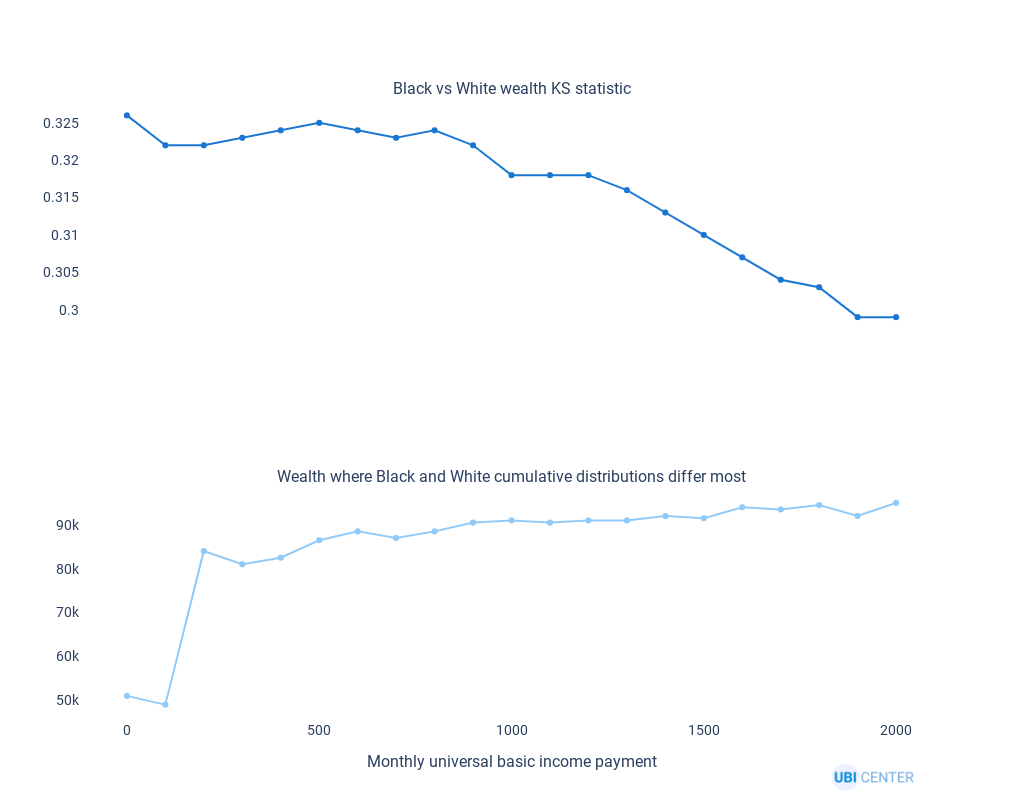

In [6]:
fig = make_subplots(
    rows=2,
    cols=1,
    shared_xaxes=True,
    x_title="Monthly universal basic income payment",
    subplot_titles=[
        "Black vs White wealth KS statistic",
        "Wealth where Black and White cumulative distributions differ most",
    ],
)

fig.add_trace(
    go.Scatter(
        x=ubi_summary.ubi_mo,
        y=ubi_summary.d_stat_cand.round(3),
        mode="lines+markers",
        name="KS statistic",
        marker_color=BLUE,
    ),
    row=1,
    col=1,
)
fig.add_trace(
    go.Scatter(
        x=ubi_summary.ubi_mo,
        y=ubi_summary.networth_pa_new,
        mode="lines+markers",
        name="Wealth at KS D-stat",
        marker_color=LIGHT_BLUE,
    ),
    row=2,
    col=1,
)

fig.update_layout(showlegend=False, hovermode="x", xaxis_tickprefix="$")

ubicenter.format_fig(fig)

Further, without UBI the median White family has \$6.45 for every \$1 held by the median Black family. Under a \$1,000 monthly payment, this falls to \$3.49 for every \$1, and further down to \$2.64 with a \$2,000 monthly payment. 
 
The median wealth for White families rises from \$115,103 without a UBI to \$119,425 under a \$1,000 monthly payment, and rises to \$127,505 with a \$2,000 monthly payment.
For Black families, a \$1,000 UBI nearly doubles the median wealth, from \$17,853 to \$34,183, and a \$2,000 monthly benefit grows it further to \$48,310.

It should be noted that the median wealth per adult[^peradult] rises among White families, it merely rises by less than that of Black families.

[^peradult]: Family wealth conventionally adjusts for number of adults to avoid distorting statistics due to marriage patterns; for example, see [Credit Suisse's Global Net Worth Report](https://www.credit-suisse.com/about-us/en/reports-research/global-wealth-report.html).

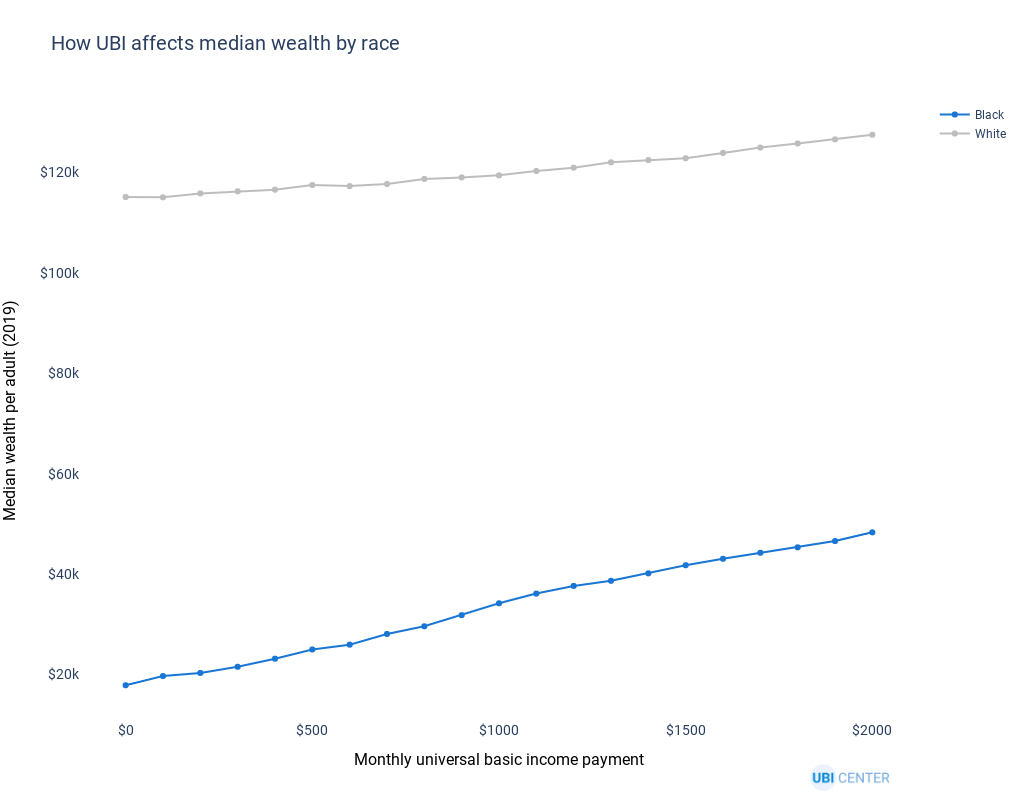

In [7]:
fig = go.Figure()

hovertemplate = "$%{y:.0f}"

fig.add_trace(
    go.Scatter(
        x=ubi_summary.ubi_mo,
        y=ubi_summary.black_median_networth_pa,
        mode="lines+markers",
        name="Black",
        marker_color=BLUE,
        hovertemplate=hovertemplate,
    )
)
fig.add_trace(
    go.Scatter(
        x=ubi_summary.ubi_mo,
        y=ubi_summary.white_median_networth_pa,
        mode="lines+markers",
        name="White",
        marker_color=GRAY,
        hovertemplate=hovertemplate,
    )
)

fig.update_layout(
    title="How UBI affects median wealth by race",
    xaxis_title="Monthly universal basic income payment",
    yaxis_title="Median wealth per adult (2019)",
    yaxis_ticksuffix="",
    yaxis_tickprefix="$",
    xaxis_tickprefix="$",
)

ubicenter.format_fig(fig)

Unlike the rising median wealth for White families under the same UBI, mean wealth for White families declines from \$557,216 without any UBI to 555,135 under a \$1,000 monthly payment, and falls further to \$553,054 with a \$2,000 monthly payment.
For Black families, the mean wealth rises from \$97,167 to \$104,768 with a \$1,000 benefit, and further to \$112,369 with a \$2,000 benefit.

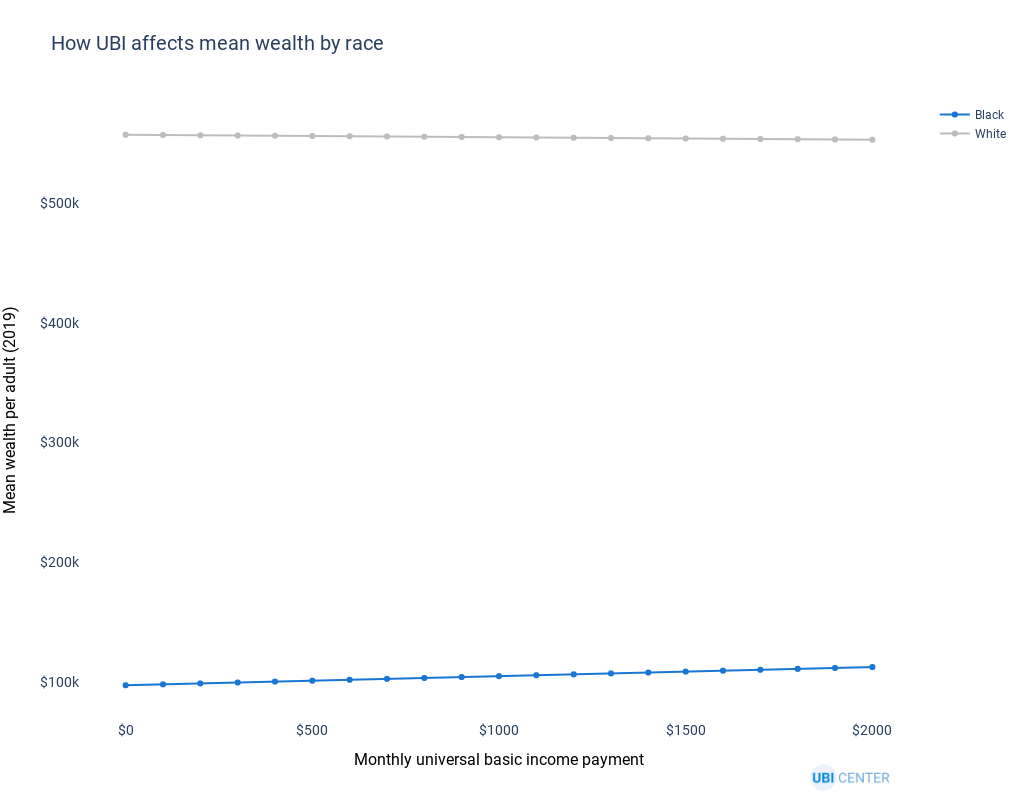

In [8]:
fig = go.Figure()

hovertemplate = "$%{y:.0f}"

fig.add_trace(
    go.Scatter(
        x=ubi_summary.ubi_mo,
        y=ubi_summary.black_mean_networth_pa,
        mode="lines+markers",
        name="Black",
        marker_color=BLUE,
        hovertemplate=hovertemplate,
    )
)
fig.add_trace(
    go.Scatter(
        x=ubi_summary.ubi_mo,
        y=ubi_summary.white_mean_networth_pa,
        mode="lines+markers",
        name="White",
        marker_color=GRAY,
        hovertemplate=hovertemplate,
    )
)

fig.update_layout(
    title="How UBI affects mean wealth by race",
    xaxis_title="Monthly universal basic income payment",
    yaxis_title="Mean wealth per adult (2019)",
    yaxis_ticksuffix="",
    yaxis_tickprefix="$",
    xaxis_tickprefix="$",
)

ubicenter.format_fig(fig)

Finally, we look at the share of families that fall below \$50,000 per adult, the point at which those two curves were further apart in our baseline scenario.

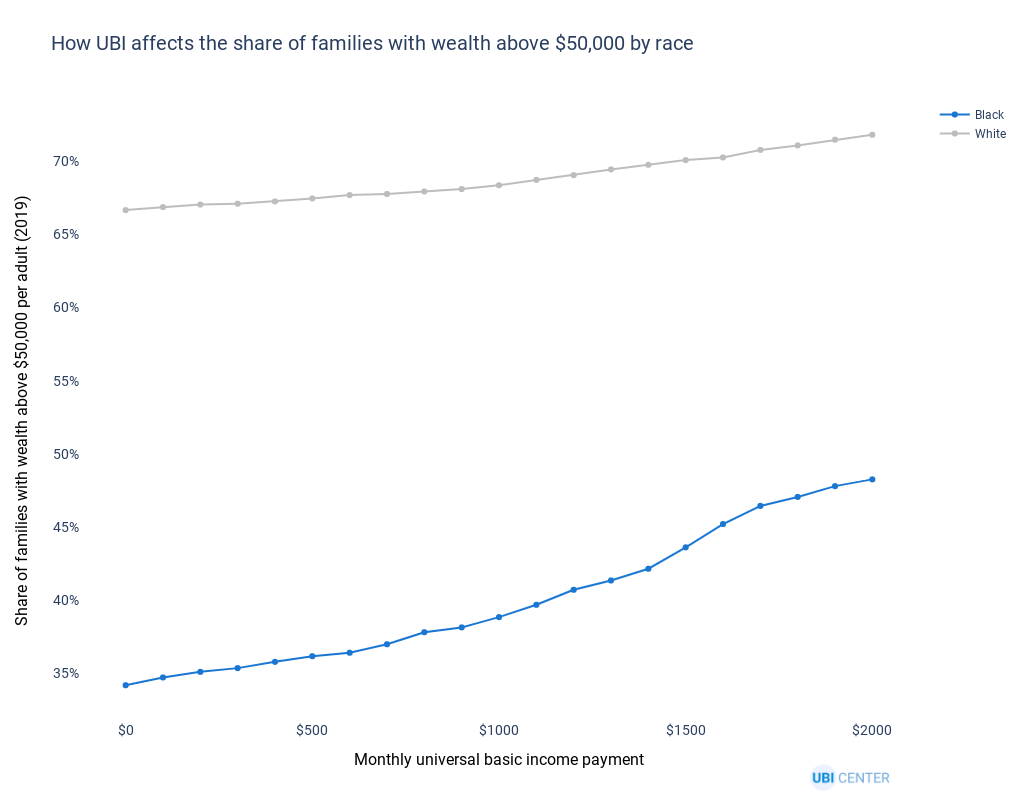

In [9]:
fig = go.Figure()
hovertemplate = "%{y:.0f}%"

fig.add_trace(
    go.Scatter(
        x=ubi_summary["ubi_mo"],
        y=ubi_summary["black_share_above_50k"] * 100,
        mode="lines+markers",
        name="Black",
        marker_color=BLUE,
        hovertemplate=hovertemplate,
    )
)
fig.add_trace(
    go.Scatter(
        x=ubi_summary["ubi_mo"],
        y=ubi_summary["white_share_above_50k"] * 100,
        mode="lines+markers",
        name="White",
        marker_color=GRAY,
        hovertemplate=hovertemplate,
    )
)

fig.update_layout(
    title="How UBI affects the share of families with wealth above $50,000 by race",
    xaxis_title="Monthly universal basic income payment",
    yaxis_title="Share of families with wealth above $50,000 per adult (2019)",
    yaxis_ticksuffix="%",
    yaxis_tickprefix="",
    xaxis_tickprefix="$",
)

ubicenter.format_fig(fig)

The share of Black families with a per adult networth of over \$50,000 rises from 65.9 percent to 61.2 percent when we raise the monthly UBI to \$1,000 monthly, and falls further to 51.7 percent when we raise the benefit to \$2,000 monthly.

In the scenarios we explore, the outcomes for Black families improve in the share of families with wealth per adult below \$50,000 declines, median family wealth increases.
In the final plot below, you can explore the relative changes in all of the metrics we've chosen.

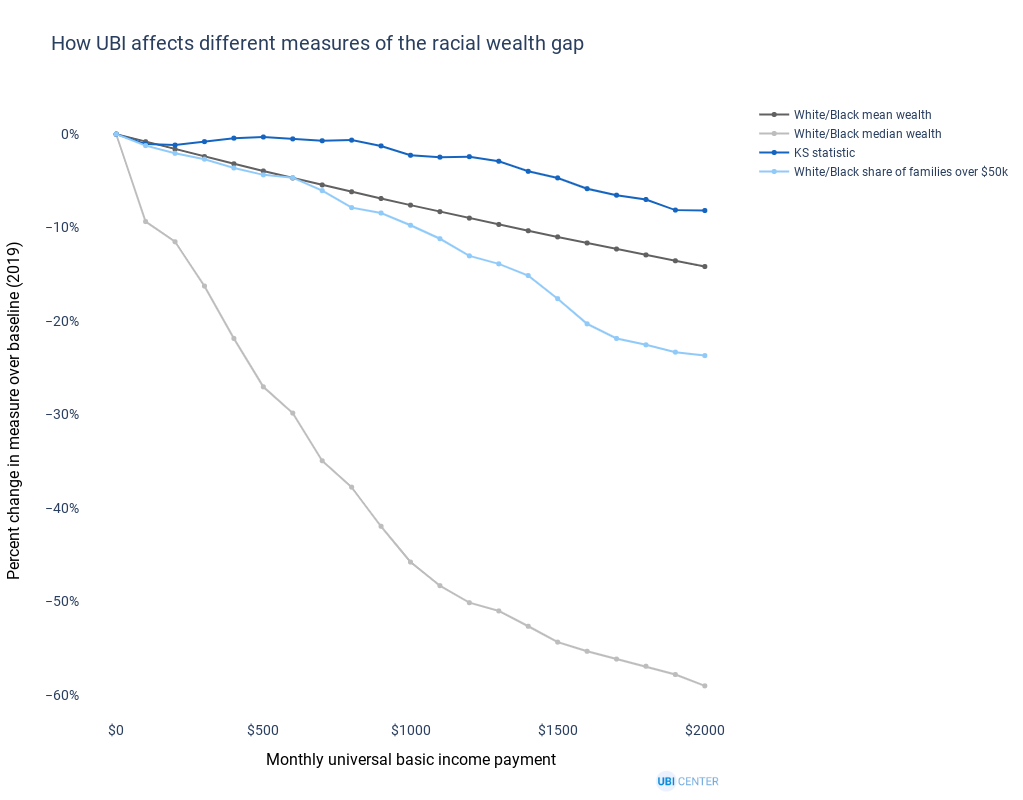

In [10]:
fig = go.Figure()


def trace(col, chg_col, name, string, color):
    """
    Args:
        col: Column name.
        chg_col: Column name of change.
        name: Name of column for printing.
        string: Formatting of customdata[1].
        color: Line color.
    """
    fig.add_trace(
        go.Scatter(
            x=ubi_summary["ubi_mo"],
            y=ubi_summary[chg_col] * 100,
            mode="lines+markers",
            name=name,
            marker_color=color,
            marker=dict(size=5),
            customdata=np.stack((ubi_summary.ubi_mo, ubi_summary[col]), axis=-1),
            hovertemplate=name
            + ": "
            + string
            + "<br>"
            + "Percent change: %{y:.0f}%<br>",
        )
    )


trace(
    "white_mean_nw_as_pct_of_mean_black",
    "white_mean_nw_as_pct_of_mean_black_pc",
    "White/Black mean wealth",
    "%{customdata[1]: .1f}",
    DARK_GRAY,
)
# median wealth
trace(
    "white_median_nw_as_pct_of_median_black",
    "white_median_nw_as_pct_of_median_black_pc",
    "White/Black median wealth",
    "%{customdata[1]: .1f}",
    GRAY,
)
trace(
    "d_stat_cand", "d_stat_cand_pc", "KS statistic", "%{customdata[1]: .3f}", DARK_BLUE
)
trace(
    "white_share_above_50k_pct_of_black",
    "white_share_above_50k_pct_of_black_pc",
    "White/Black share of families over $50k",
    "%{customdata[1]: .1f}",
    LIGHT_BLUE,
)

fig.update_layout(
    title="How UBI affects different measures of the racial wealth gap",
    xaxis_title="Monthly universal basic income payment",
    yaxis_title="Percent change in measure over baseline (2019)",
    yaxis_ticksuffix="%",
    yaxis_tickprefix="",
    xaxis_tickprefix="$",
)

ubicenter.format_fig(fig)

While these metrics aren't truly comparable, we can see that the KS statistic is more stubborn than other measures, especially the gap in median wealth.
Median Black wealth is so low that even modest redistribution can close that gap quickly, but larger gaps in the middle of the distribution will persist.

We will continue this line of research, especially longer-term dynamic analysis to reflect the accumulative nature of wealth.
Our simplifying assumption that the entire tax and transfer system flows straight to wealth, rather than consumption, may exaggerate these trends given propensities to consume decrease with wealth. But recurring redistribution would likely have a significantly larger effect in closing the gap, even accounting for consumption.
UBI isn't the only policy that can reduce racial wealth disparities, but it certainly helps.